In [1]:
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

import os
import subprocess


In [2]:
! nividia-smi

/bin/bash: nividia-smi: command not found


In [12]:
# Print the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /u/dzhou2/Project/CUDA-project-for-IE533/Code


In [23]:
! make clean
! make all 

rm -fr ./main.o ./lib/cuda/cuda_ssp.o ./lib/ssp.o ./lib/cuda/cuda_ssp.d ./main.d ./lib/ssp.d stochastic_shortest_path
 
NVCC compiler building file: main.cpp
nvcc -O3 -std=c++11 -gencode arch=compute_61,code=sm_61  -odir "." -M -o "main.d" "main.cpp"
nvcc -O3 -std=c++11 --compile  -x c++ -o  "main.o" "main.cpp"
Finished building: main.cpp
 
NVCC compiler building file: lib/cuda/cuda_ssp.cu
nvcc -O3 -std=c++11 -gencode arch=compute_61,code=sm_61  -odir "lib/cuda" -M -o "lib/cuda/cuda_ssp.d" "lib/cuda/cuda_ssp.cu"
nvcc -O3 -std=c++11 --compile --relocatable-device-code=false -gencode arch=compute_61,code=compute_61 -gencode arch=compute_61,code=sm_61  -x cu -o  "lib/cuda/cuda_ssp.o" "lib/cuda/cuda_ssp.cu"
Finished building: lib/cuda/cuda_ssp.cu
 
NVCC compiler building file: lib/ssp.cpp
nvcc -O3 -std=c++11 -gencode arch=compute_61,code=sm_61  -odir "lib" -M -o "lib/ssp.d" "lib/ssp.cpp"
nvcc -O3 -std=c++11 --compile  -x c++ -o  "lib/ssp.o" "lib/ssp.cpp"
Finished building: lib/ssp.cpp
 
Li

In [24]:
folder_path = './data/'

big_graphs = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
big_graphs.sort()
print(big_graphs)

['V1000-E150000', 'V10000-E2000000', 'V12500-E3125000', 'V2000-E400000', 'V5000-E500000', 'V7500-E1125000']


In [25]:
commands = []

for graph in big_graphs:
    for Algorithm in range(3):
        commands.append(f"./stochastic_shortest_path -a {Algorithm} < ./data/{graph}")

In [26]:
# You'd better to run this in a terminal
commands

['./stochastic_shortest_path -a 0 < ./data/V1000-E150000',
 './stochastic_shortest_path -a 1 < ./data/V1000-E150000',
 './stochastic_shortest_path -a 2 < ./data/V1000-E150000',
 './stochastic_shortest_path -a 0 < ./data/V10000-E2000000',
 './stochastic_shortest_path -a 1 < ./data/V10000-E2000000',
 './stochastic_shortest_path -a 2 < ./data/V10000-E2000000',
 './stochastic_shortest_path -a 0 < ./data/V12500-E3125000',
 './stochastic_shortest_path -a 1 < ./data/V12500-E3125000',
 './stochastic_shortest_path -a 2 < ./data/V12500-E3125000',
 './stochastic_shortest_path -a 0 < ./data/V2000-E400000',
 './stochastic_shortest_path -a 1 < ./data/V2000-E400000',
 './stochastic_shortest_path -a 2 < ./data/V2000-E400000',
 './stochastic_shortest_path -a 0 < ./data/V5000-E500000',
 './stochastic_shortest_path -a 1 < ./data/V5000-E500000',
 './stochastic_shortest_path -a 2 < ./data/V5000-E500000',
 './stochastic_shortest_path -a 0 < ./data/V7500-E1125000',
 './stochastic_shortest_path -a 1 < ./data/

In [33]:
# Run the commands and capture the output in a list
outputs = []
for command in commands:
    output = subprocess.check_output(command, shell=True)
    outputs.append(command + ' ' + output.decode())

no CUDA-capable device is detected in lib/cuda/cuda_ssp.cu at line 349


CalledProcessError: Command './stochastic_shortest_path -a 1 < ./data/V1000-E150000' returned non-zero exit status 1.

In [34]:
# Print the outputs

print(outputs)

['./stochastic_shortest_path -a 0 < ./data/V1000-E150000 Compute time: 941 ms\n']


In [18]:
# RECORD THE COMPUTATION TIME Manually
record = {
    "Vertices #": ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'],
    "Edges #": ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'],
    "compute_time of C++": [380, 3518, 54874, 183425, 428358, 840263],
    "compute_time of CUDA": [313, 384, 1820, 5223, 12228, 24836],
    "compute_time of Well Designed CUDA": [304, 295, 721, 1573, 3303, 7092],
}

df = pd.DataFrame(record)

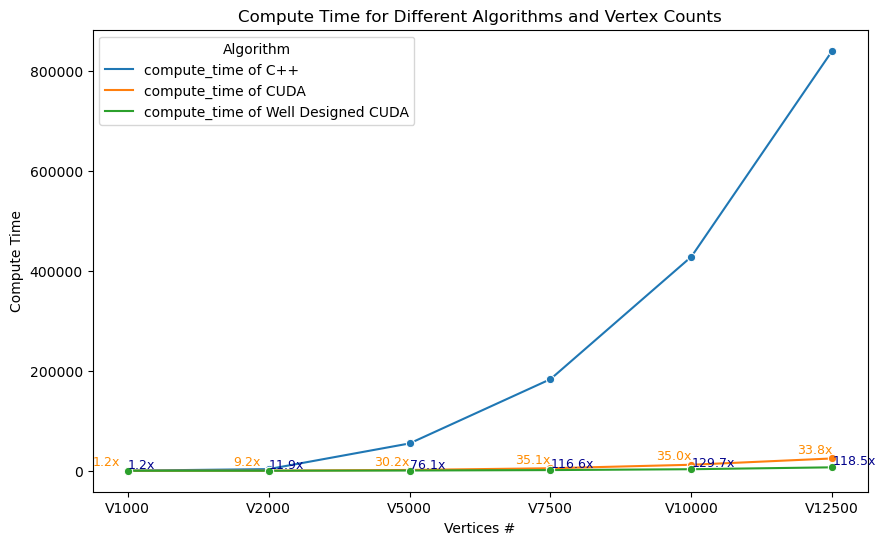

In [19]:
df_melted = df.melt(id_vars=['Vertices #', 'Edges #'], var_name='Algorithm', value_name='Compute Time')

# Calculate the speedup factor
speedup_cuda = [cpp_time / cuda_time for cpp_time, cuda_time in zip(df['compute_time of C++'], df['compute_time of CUDA'])]
speedup_well_designed_cuda = [cpp_time / well_designed_cuda_time for cpp_time, well_designed_cuda_time in zip(df['compute_time of C++'], df['compute_time of Well Designed CUDA'])]

# Line plot with speedup annotations
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Vertices #', y='Compute Time', hue='Algorithm', marker='o')
plt.title("Compute Time for Different Algorithms and Vertex Counts")

# Add speedup annotations to the plot
for i, (speedup1, speedup2) in enumerate(zip(speedup_cuda, speedup_well_designed_cuda)):
    plt.annotate(f"{speedup1:.1f}x", (i - 0.25, df['compute_time of CUDA'][i] + 10000), fontsize=9, color='darkorange')
    plt.annotate(f"{speedup2:.1f}x", (i, df['compute_time of Well Designed CUDA'][i] + 5000), fontsize=9, color='darkblue')

plt.show()

/tmp/ipykernel_2752513/3079671596.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df['Edges #'], rotation=45)
/tmp/ipykernel_2752513/3079671596.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df['Edges #'], rotation=45)
/tmp/ipykernel_2752513/3079671596.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(df['Edges #'], rotation=45)


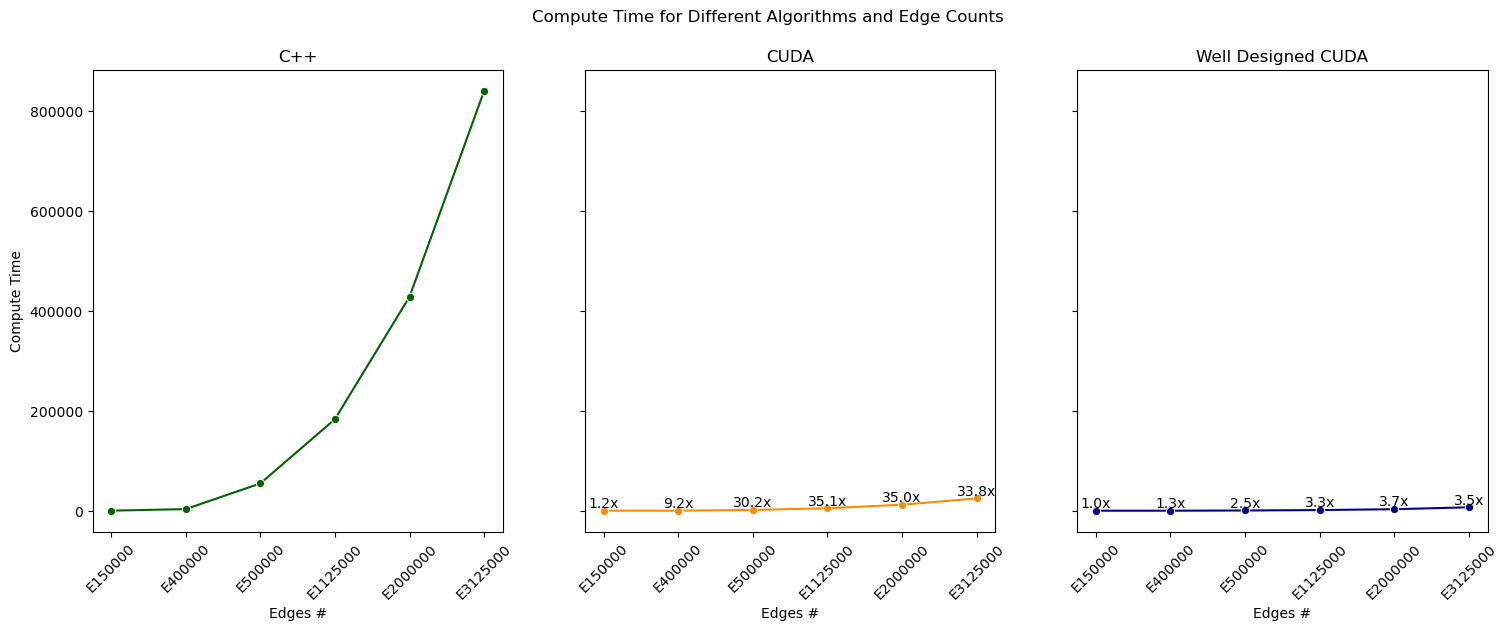

In [20]:
# Calculate speedup compared to C++
df['CUDA_speedup'] = df['compute_time of C++'] / df['compute_time of CUDA']
df['Well Designed CUDA_speedup'] = df['compute_time of CUDA'] / df['compute_time of Well Designed CUDA']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Compute Time for Different Algorithms and Edge Counts")

sns.lineplot(ax=axes[0], data=df, x='Edges #', y='compute_time of C++', marker='o', color='darkgreen')
axes[0].set_title("C++")
axes[0].set_ylabel("Compute Time")
axes[0].set_xticklabels(df['Edges #'], rotation=45)

sns.lineplot(ax=axes[1], data=df, x='Edges #', y='compute_time of CUDA', marker='o', color='darkorange')
axes[1].set_title("CUDA")
axes[1].set_ylabel("")
axes[1].set_xticklabels(df['Edges #'], rotation=45)

sns.lineplot(ax=axes[2], data=df, x='Edges #', y='compute_time of Well Designed CUDA', marker='o', color='darkblue')
axes[2].set_title("Well Designed CUDA")
axes[2].set_ylabel("")
axes[2].set_xticklabels(df['Edges #'], rotation=45)

# Annotate speedup compared to C++
for i, row in df.iterrows():
    axes[1].text(row['Edges #'], row['compute_time of CUDA'], f"{row['CUDA_speedup']:.1f}x", ha='center', va='bottom')
    axes[2].text(row['Edges #'], row['compute_time of Well Designed CUDA'], f"{row['Well Designed CUDA_speedup']:.1f}x", ha='center', va='bottom')

plt.show()